### Задача 2.

Анализ результатов эксперимента. Эксперимент проходил с 2022-05-24 по 2022-05-30 включительно. Для эксперимента были задействованы 2 и 1 группы. 

В группе 2 был использован один из новых алгоритмов рекомендации постов, группа 1 использовалась в качестве контроля. 

Основная гипотеза заключается в том, что новый алгоритм во 2-й группе приведет к увеличению CTR. 

In [77]:
import pandahouse
import swifter
import hashlib
import seaborn as sns
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt

In [78]:
#выгружаем данные из clickhouse

connection = {
    'host': '********',
    'password': '*********',
    'user':'*******',
    'database':'***********'
}

q = """
select exp_group, user_id, 
       sum(action = 'like') as likes,
       sum(action = 'view') as views,
       likes/views as ctr
from {db}.feed_actions
where toDate(time) >= '2022-05-24' and toDate(time) <= '2022-05-30'
      and exp_group in (1, 2)
group by exp_group, user_id
"""

df = pandahouse.read_clickhouse(q, connection = connection)
df.head(5)

,exp_group,user_id,likes,views,ctr
0,1,109963,3,15,0.200000
1,1,26117,32,141,0.226950
2,1,138232,18,73,0.246575
3,1,26295,33,122,0.270492
4,1,18392,7,32,0.218750


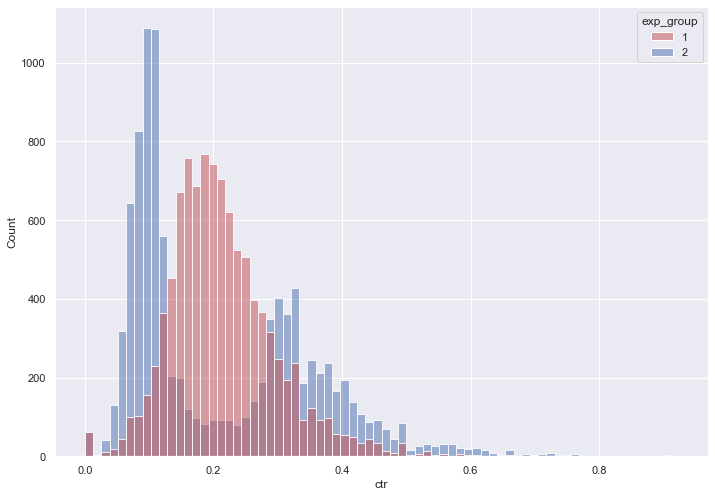

In [79]:
#визуализация распределения ctr для двух групп пользователей

sns.set(rc = {'figure.figsize':(11.7, 8.27)})

groups = sns.histplot(data = df, 
                      x = 'ctr',
                      hue = 'exp_group',
                      palette = ['r', 'b'],
                      alpha = 0.5,
                      kde = False)

Во-первых, видно, что распределение во второй группе не является унимодальным, в отличие от распределения в первой группе.

In [80]:
#реализация t-теста
stats.ttest_ind(df[df['exp_group']==1].ctr,
                df[df['exp_group']==2].ctr,
                equal_var = False)

Ttest_indResult(statistic=0.7094392041270486, pvalue=0.4780623130874935)

t-тест сравнивает средние значения в двух выборках. 
Так как вторая выборка не является унимодальной, то среднее для нее нельзя назвать показательным. В то же время средние этих двух выборок действительно могут быть близки, что нам и показал t-тест (что нет статистической разницы между этими двумя выборками).

In [81]:
#ради интереса посмотрим средние в этих выборках
df[df['exp_group']==1].ctr.mean(), df[df['exp_group']==2].ctr.mean()

(0.21560459841296403, 0.21441927347479056)

Видно, что средние значения действительно близки, однако даже по форме распределений видно, что различия между ними есть.

In [53]:
#реализация теста Манна-Уитни
stats.mannwhitneyu(df[df.exp_group == 1].ctr,
                   df[df.exp_group == 2].ctr)

MannwhitneyuResult(statistic=56601260.5, pvalue=6.0376484617779035e-56)

Тест Манна-Уитни наоборот показывает, что p_value стремится к нулю, а значит различия между выборками значительные.

Это происходит потому, что тест Манна-Уитни проверяет достаточно ли мала зона перекрещивающихся значений между двумя выборками (ранжированным рядом значений параметра в первой выборке и таким же во второй выборке). 

На визуализации видно, что зона перекрещивающихся значений мала, как раз из-за того, что второе распределение имеет две моды. Поэтому тест и показал значение p_value близкое к нулю.

### t-test на сглаженном ctr

In [54]:
#t-test на сглаженном ctr
#функция расчета сглаженного ctr

def get_smoothed_ctr(user_likes, user_views, global_ctr, alpha):
    smoothed_ctr = (user_likes + alpha * global_ctr) / (user_views + alpha)
    return smoothed_ctr

In [18]:
#расчет глобальных ctr

global_ctr_1 = df[df.exp_group == 1].likes.sum()/df[df.exp_group == 1].views.sum()
global_ctr_2 = df[df.exp_group == 2].likes.sum()/df[df.exp_group == 2].views.sum()

#расчет smoothed_ctr для каждой группы
group1 = df[df.exp_group == 1].copy()

group1['smoothed_ctr'] = df.apply(
       lambda x: get_smoothed_ctr(x['likes'], x['views'], global_ctr_1, 5), axis = 1)

group2 = df[df.exp_group == 2].copy()

group2['smoothed_ctr'] = df.apply(
      lambda x: get_smoothed_ctr(x['likes'], x['views'], global_ctr_2, 5), axis = 1)

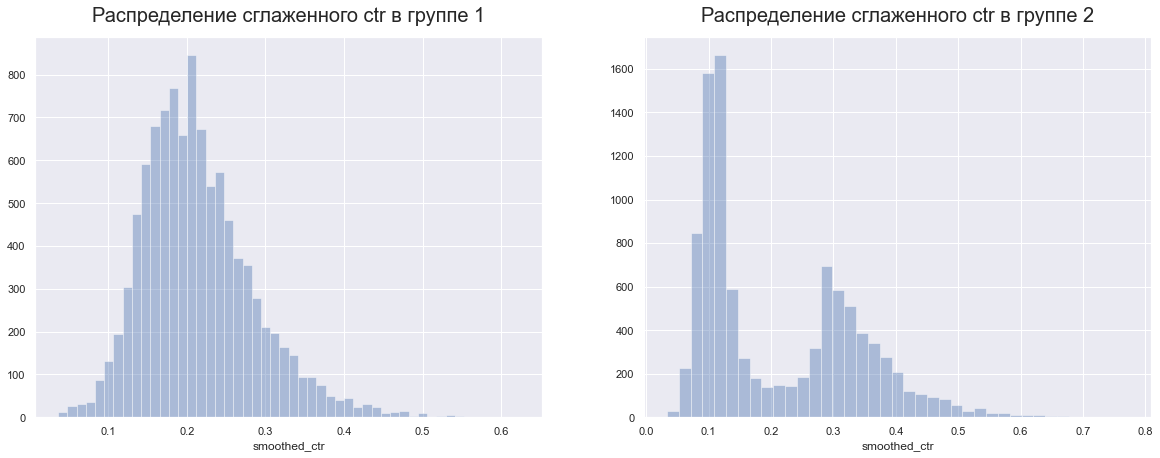

In [62]:
#визуализация распределения сглаженного ctr для двух групп пользователей 

fig = plt.subplots(figsize = (20, 7))

plt.subplot(1, 2, 1)
sns.distplot(group1.smoothed_ctr, kde = False)
plt.title('Распределение сглаженного ctr в группе 1', fontsize = 20, pad = 15)

plt.subplot(1, 2, 2)
sns.distplot(group2['smoothed_ctr'], kde = False)
plt.title('Распределение сглаженного ctr в группе 2', fontsize = 20, pad = 15)

plt.show()

In [63]:
stats.ttest_ind(group1.smoothed_ctr, 
                group2.smoothed_ctr,
                equal_var = False)

Ttest_indResult(statistic=1.3692822886076694, pvalue=0.17093053814006512)

После выполнения сглаживания ctr  t-тест все еще показывает, что значимого различия нет, но значение p_value уменьшилось по сравнению с t-тестом на несглаженном ctr (0.47 против 0.17).

In [84]:
#опять же сравним средние значения сглаженных ctr в двух группах
group1.smoothed_ctr.mean(), group2.smoothed_ctr.mean()

(0.21414168642770554, 0.21216989112932247)

### Пуассоновский бутстреп

In [64]:
#функция пуассоновского бутстрепа для подсчета разницы в CTR
def bootstrap (likes1, likes2, views1, views2, n_bootstrap = 2000):
    
    poisson_bootstraps1 = stats.poisson(1).rvs(
    (n_bootstrap, len(likes1))).astype(np.int64)
    
    poisson_bootstraps2 = stats.poisson(1).rvs(
    (n_bootstrap, len(likes2))).astype(np.int64)
    
    globalCTR1 = (poisson_bootstraps1*likes1).sum(axis = 1)/(poisson_bootstraps1*views1).sum(axis = 1)
    globalCTR2 = (poisson_bootstraps2*likes2).sum(axis = 1)/(poisson_bootstraps2*views2).sum(axis = 1)
    
    return globalCTR1, globalCTR2

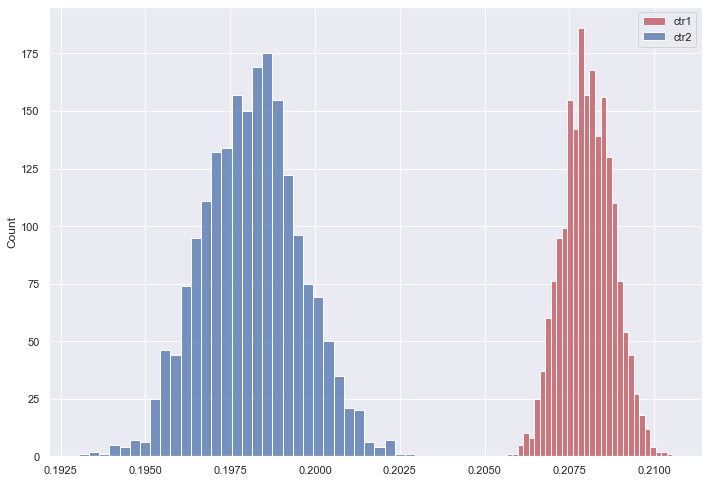

In [87]:
#реализация пуассоновского бутстрепа
likes1 = df[df.exp_group == 1].likes.to_numpy()
views1 = df[df.exp_group == 1].views.to_numpy()

likes2 = df[df.exp_group == 2].likes.to_numpy()
views2 = df[df.exp_group == 2].views.to_numpy()

ctr1, ctr2 = bootstrap(likes1, likes2, views1, views2)

sns.histplot(ctr1, label = 'ctr1', color = 'r')
sns.histplot(ctr2, label = 'ctr2')
plt.legend()

<AxesSubplot:ylabel='Count'>

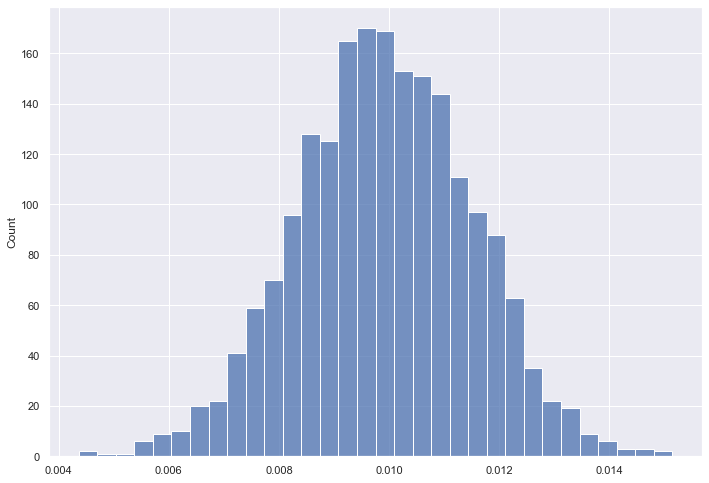

In [88]:
#распределение разности между глобальными ctr
sns.histplot(ctr1 - ctr2)

Выборки не пересекаются между собой и разница между глобальными ctr не пересекается с нулем, а значит p_value = 0 и значимые различия между двумя этими выборками есть.

Бутстреп не требователен к форме распределения, что важно в нашем случае. 

### Реализация бакетного преобразования

In [67]:
#реализация бакетного преобразования в clickhouse
q = """
select exp_group, bucket,
       sum(likes)/sum(views) as bucket_ctr
from (select exp_group,
             xxHash64(user_id)%50 as bucket,
             user_id,
             sum(action = 'like') as likes, 
             sum(action = 'view') as views,
             likes/views as ctr
     from {db}.feed_actions
     where toDate(time) between '2022-05-24' and '2022-05-30'
           and exp_group in (1, 2)
     group by exp_group, bucket, user_id)
group by exp_group, bucket
           
"""

df = pandahouse.read_clickhouse(q, connection = connection)

In [69]:
#t-test поверх бакетного преобразования
stats.ttest_ind(df[df.exp_group == 1].bucket_ctr,
                df[df.exp_group == 2].bucket_ctr,
                equal_var = False)

Ttest_indResult(statistic=5.668234732053979, pvalue=3.4455951649945907e-07)

In [ ]:
#тест Манна-Уитни поверх бакетного преобразования

In [70]:
stats.mannwhitneyu(df[df.exp_group == 1].bucket_ctr,
                   df[df.exp_group == 2].bucket_ctr,
                   alternative = 'two-sided')

MannwhitneyuResult(statistic=1995.0, pvalue=2.859963936492646e-07)

Здесь в обоих тестах p_value значительно мало, а значит различия между выборками есть. 

Применяя бакетное преобразование мы в каком-то смысле решаем проблему мультимодальности распределения ctr во второй группе и приводя в том или ином виде ctr во второй группе к виду нормального распределения. 

Поэтому оба теста поверх бакетного распределения показывают нам примерно одинаковый результат.

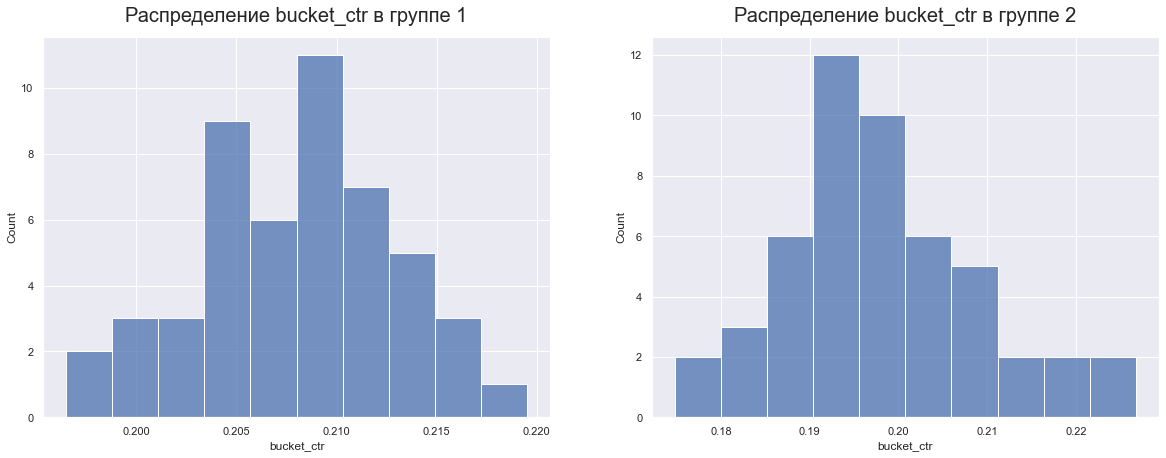

In [74]:
fig = plt.subplots(figsize = (20, 7))

plt.subplot(1, 2, 1)
sns.histplot(df[df.exp_group == 1].bucket_ctr, bins = 10)
plt.title('Распределение bucket_ctr в группе 1', fontsize = 20, pad = 15)

plt.subplot(1, 2, 2)
sns.histplot(df[df.exp_group == 2].bucket_ctr, bins = 10)
plt.title('Распределение bucket_ctr в группе 2', fontsize = 20, pad = 15)

plt.show()

### Итоги

- t-test и тест Манна-Уитни показали абсолютно противополжный результат: t-test показал, что разницы между выборками нет, тест Манна-Уитни показал, что разница очень велика;

- после сглаживания ctr t-test все равно не показал разницы между первой и второй группой, потому что сглаживание не повлияло на распределение второй группы, которое не было унимодальным;

- пуассоновский бутстреп и реализация тестов поверх бакетного преобразования показало наличие статистической разницы в первой и второй группах;

- можно предположить, что у нас в ходе эксперимента образовалось две группы пользователей: одни ставили примерно 10 лайков на 100 просмотров (причем это бОльшая группа пользователей), другие примерно 30 лайков на 100 просмотров. 

  В контрольной группе показатель примерно 20 лайков на 100 просмотров. 

  Исходя из этого можно сказать, что изначальная группа пользователей разделилась на тех, кто стал ставить больше лайков и тех, кто стал ставить меньше лайков. Причем тех, кто стал ставить меньше лайков бОльшее число.
 
- исходя из этих соображений я бы не рекомендовала раскатывать новый алгоритм на всех пользователей на основании текущих результатов. 

- возможно, на этот эксперимент наложились какие-то другие факторы и влияние на пользователей оказал не алгоритм, можно попробовать провести еще один аналогичный эксперимент на других группах пользователей, чтобы дать уже окончательную оценку эффективности алгоритма.